In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Read in model file names

In [2]:
read_path = "dataGeneration/feature_target_test_out"
model_path = "dataGeneration/model_test_out"


feature_target_dir = os.path.join(os.getcwd(), read_path)
feature_target_files = os.listdir(feature_target_dir)
print("Total feature_target number: ", len(feature_target_files))

model_dir = os.path.join(os.getcwd(), model_path)
model_files = os.listdir(model_dir)
print("Total model number: ", len(model_files))


Total feature_target number:  63
Total model number:  63


In [3]:
sample = []

for file in feature_target_files:
    with open(os.path.join(feature_target_dir, file), 'rb') as f:
        loaded_dict = pickle.load(f)
        sample.append(loaded_dict)
        f.close()


### Normalizing data

In [4]:
loadMatrix = np.array([x["Load"] for x in sample])
solarMatrix = np.array([x["Solar"] for x in sample])

nbScen = solarMatrix.shape[1]
nbBus = loadMatrix.shape[1]
nbSolar = solarMatrix.shape[2]
nbTime = loadMatrix.shape[2]
nbSample = loadMatrix.shape[0]

print(loadMatrix.shape, solarMatrix.shape)
print(nbScen, nbBus, nbSolar, nbTime)

(63, 66, 48) (63, 5, 3, 48)
5 66 3 48


In [5]:
loadScaler = MinMaxScaler()
solarScaler = MinMaxScaler()

loadScaler.fit(loadMatrix.reshape(nbSample, -1))
solarScaler.fit(solarMatrix.reshape(nbSample, -1))

loadNormalized = loadScaler.transform(loadMatrix.reshape(nbSample, -1))
solarNormalized = solarScaler.transform(solarMatrix.reshape(nbSample, -1))

loadNormalized = loadNormalized.reshape(-1, nbBus, nbTime)
solarNormalized = solarNormalized.reshape(nbSample, -1, nbSolar, nbTime)

# plt.plot(solarNormalized[0, 1,:])
print(loadNormalized.shape, solarNormalized.shape)

(63, 66, 48) (63, 5, 3, 48)


### Plot out Solar to make sure reshape is fine

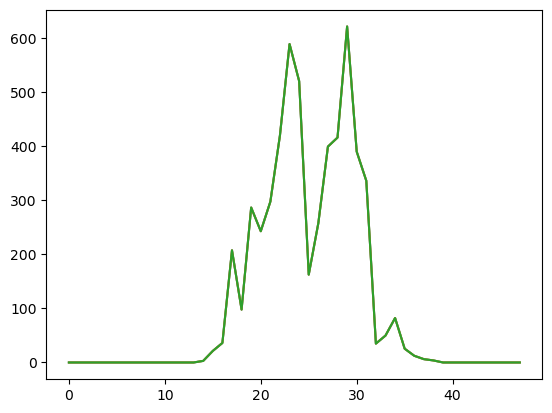

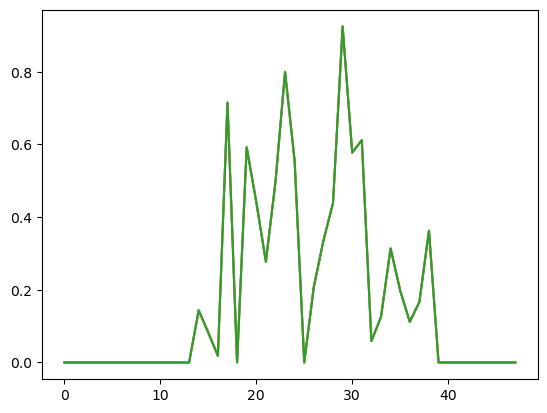

In [6]:
ScenNum = 2
num = 3
# for i in range(5):
for j in range(nbSolar):
    plt.plot(solarMatrix[ScenNum,num,j,:])

plt.show()

for k in range(nbSolar):
    plt.plot(solarNormalized[ScenNum,num,k,:])

plt.show()

### Check Database EV Number

In [7]:
charging_station = np.squeeze(pd.read_csv(os.path.join(os.path.join(os.getcwd(), 'systemData'), 'cs_params_variable.csv')).to_numpy())
nbCS = len(charging_station)

data_dir = os.path.join(os.getcwd(), 'systemData')
EV_routes = pd.read_csv(os.path.join(data_dir, 'EV_routes.csv')).to_numpy()
nbRoute = EV_routes.shape[0]

# uncomment to check number of EV in dataset
unique, counts = np.unique([x["Binary"].shape[0] / (nbRoute*(nbTime-1) + nbCS*nbTime*2) for x in sample], return_counts=True)
print(dict(zip(unique, counts)))

binaryList = [x["Binary"].reshape(-1,1) for x in sample]
indicesList = [x["Indices"].reshape(-1,1) for x in sample]
scheduleList = [x["Schedule"].astype("int16") for x in sample]

print(binaryList[7].shape, indicesList[7].shape, scheduleList[7].shape)



{505.0: 5, 510.0: 5, 515.0: 5, 520.0: 5, 525.0: 5, 530.0: 5, 535.0: 5, 540.0: 5, 545.0: 5, 550.0: 5, 555.0: 5, 560.0: 5, 565.0: 3}
(3989960, 1) (3989960, 1) (416, 3)


### Preprocessing schedules

In [8]:
# transform schedule to time array
processedScheduleList = []

for i in range(len(scheduleList)):

    scheduleArray = np.zeros((int(scheduleList[i].shape[0]/4), nbTime))

    for s in range(scheduleList[i].shape[0]):
        scheduleArray[scheduleList[i][s,0], scheduleList[i][s,2]] = scheduleList[i][s,1]
        
    processedScheduleList.append(scheduleArray)

print(processedScheduleList[6].shape)



(103, 48)


In [9]:
# since schedule size always not the same, need to do scaler separately
destinationList = []

for i in range(len(scheduleList)):
    for s in range(scheduleList[i].shape[0]):
        destinationList.append(scheduleList[i][s,1])
        destinationList.append(scheduleList[i][s,2])

maxDest = np.max(destinationList)
print(maxDest)

107


In [10]:
# do a simple scaling (not MinMaxScaler)
scheduleListNormalized = []

for i in range(len(processedScheduleList)):
    scheduleListNormalized.append(processedScheduleList[i]/maxDest)

print(len(scheduleListNormalized))

63


### Append Features together

In [11]:
loadNormalized = np.repeat(loadNormalized[:, np.newaxis, :, :], nbScen, axis=1) 
scheduleNormalized = [np.repeat(x[np.newaxis, :, :], nbScen, axis=0) for x in scheduleListNormalized]

print(loadNormalized.shape)
print(scheduleNormalized[0].shape)

(63, 5, 66, 48)
(5, 101, 48)


In [12]:
featureList = []

for i in range(len(feature_target_files)):

    feature = np.append(loadNormalized[i], solarNormalized[i], axis=1)
    feature = np.append(feature, scheduleNormalized[i], axis=1)
    # feature = np.transpose(feature, (1,0))

    featureList.append(feature)

    binaryList[i] = binaryList[i].reshape(nbScen, -1)
    indicesList[i] = indicesList[i].reshape(nbScen, -1)

print(len(featureList), featureList[7].shape)
print(len(binaryList), binaryList[7].shape)
print(len(indicesList), indicesList[7].shape)

63 (5, 173, 48)
63 (5, 797992)
63 (5, 797992)


### Read in Rest of the Parameters

In [13]:
solTimeMatrix = np.array([x["solve_time"] for x in sample])
objValMatrix = np.array([x["Obj_val"] for x in sample])
nbEVMatrix = np.array([x["nbEV"] for x in sample])
modelNumMatrix = np.array([x["model"] for x in sample])

print(nbEVMatrix)

[101 101 103 103 103 103 103 104 104 104 104 104 101 105 105 105 105 105
 106 106 106 106 106 101 107 107 107 107 107 108 108 108 108 108 101 109
 109 109 109 109 110 110 110 110 110 102 111 111 111 111 111 112 112 112
 112 112 102 113 113 113 102 102 102]


### Split data for training and testing

In [14]:
feature_test = featureList
binary_test = binaryList
indices_test = indicesList
solTime_test = solTimeMatrix
objVal_test = objValMatrix
schedule_test = scheduleList
model_test = modelNumMatrix


### Save preprocessed data

In [15]:
train_test_dir = os.path.join(os.getcwd(), "dataGeneration/preprocessed_data_test_nopadding_out")

data_path = os.path.join(train_test_dir, f"X_test.pkl")
with open(data_path, 'wb') as f:
    pickle.dump(feature_test, f)

data_path = os.path.join(train_test_dir, f"y_test.pkl")
with open(data_path, 'wb') as f:
    pickle.dump(binary_test, f)

data_path = os.path.join(train_test_dir, f"indices_test.pkl")
with open(data_path, 'wb') as f:
    pickle.dump(indices_test, f)

data_path = os.path.join(train_test_dir, f"schedule_test.pkl")
with open(data_path, 'wb') as f:
    pickle.dump(schedule_test, f)

np.save(os.path.join(train_test_dir, "solTime_test.npy"), solTime_test)
np.save(os.path.join(train_test_dir, "objVal_test.npy"), objVal_test)
np.save(os.path.join(train_test_dir, "model_test.npy"), model_test)

